In [7]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Load Dataset
file_path = "data/group5.xlsx"  # Use the relative path if the file is in the same directory
df = pd.read_excel(file_path)

In [9]:
# Inspect the Data
print(df.head())
print(df.info())
print(df.describe())

       id  Gender  Age       City Profession  Academic_Pressure  \
0  116782    Male   23     Bhopal    Student                  5   
1   28324    Male   33       Pune    Student                  3   
2   97624  Female   19     Nashik    Student                  4   
3  122053    Male   25    Chennai    Student                  3   
4   67402    Male   32  Bangalore    Student                  5   

   Work_Pressure  CGPA  Study_Satisfaction  Job_Satisfaction  \
0              0  8.74                   2                 0   
1              0  7.88                   4                 0   
2              0  5.45                   1                 0   
3              0  7.74                   1                 0   
4              0  9.96                   1                 0   

      Sleep_Duration Dietary_Habits    Degree  \
0          7-8 hours      Unhealthy      B.Ed   
1          5-6 hours       Moderate       PhD   
2  More than 8 hours      Unhealthy  Class 12   
3  More than 8 h

In [10]:
# Drop ID column since it’s not useful for prediction
df.drop(columns=['id'], inplace=True)

In [11]:
# Handle Missing Values (Fill numerical columns with median, categorical with mode)
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].fillna(df[column].mode()[0])
    else:
        df[column] = df[column].fillna(df[column].median())

In [12]:
# Define Features (X) and Target (y)
X = df.drop(columns=['Depression'])  # Features
y = df['Depression']  # Target Variable
# Normalize Numerical Features
numerical_columns = ['Age', 'CGPA', 'Work_Study_Hours']  # Only numerical variables
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# One-Hot Encode Nominal Categorical Variables, including 'Sleep Duration'
nominal_columns = ['Gender', 'City', 'Profession', 'Dietary_Habits', 'Degree', 
                   'Have_you_ever_had_suicidal_thoughts_', 'Family_History_of_Mental_Illness', 
                   'Sleep_Duration']

X = pd.get_dummies(X, columns=nominal_columns, drop_first=True)  # Drop first to avoid multicollinearity

# Print the final feature set shape to verify
print("Final Feature Set Shape:", X.shape)

Final Feature Set Shape: (19999, 96)


In [13]:
# Split Data into Training & Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# Train a Random Forest Model (Handles Class Imbalance if Needed)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

Accuracy: 0.83925

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80      1666
           1       0.84      0.89      0.87      2334

    accuracy                           0.84      4000
   macro avg       0.84      0.83      0.83      4000
weighted avg       0.84      0.84      0.84      4000


Confusion Matrix:
 [[1286  380]
 [ 263 2071]]


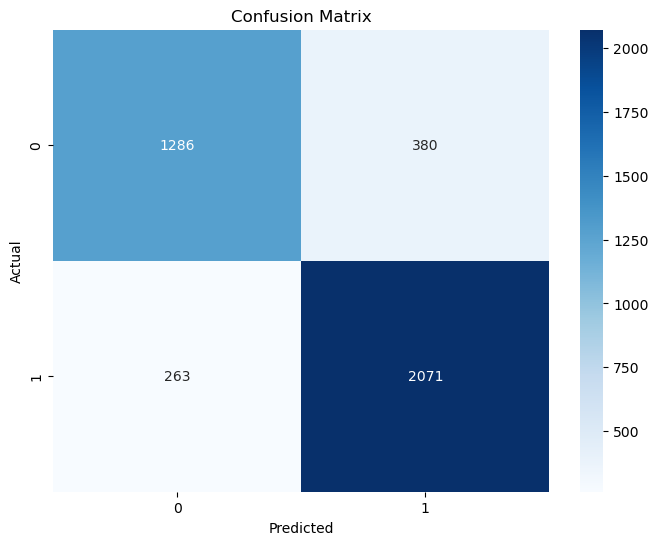

In [15]:
# Predict on Test Set
y_pred = rf_model.predict(X_test)

# Evaluate the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optional: Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [16]:
# Save the scaler
joblib.dump(scaler, 'scaler.joblib')

# Save the trained model
joblib.dump(rf_model, 'random_forest_model.joblib')

# Save the categorical options for dropdowns in the app
categorical_options = {col: df[col].unique().tolist() for col in nominal_columns}
joblib.dump(categorical_options, 'categorical_options.joblib')

# Save the feature names after one-hot encoding (for reference)
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'feature_names.joblib')

['feature_names.joblib']